# Homework 3

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.

In the 2023 course offering, pick either 1. or 2., and then 3.

**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [1]:
# Import the Obspy modules that will be useful to download seismic data
#!pip install obspy

# Import modules for seismic data and feature extraction

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.signal as signal


# seismic python toolbox
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import read, UTCDateTime, Stream

**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [2]:
# Download seismic data
network = "XH"
station = "DR01"
channel = "LHN"


# Define the time range for the data request
Tstart = UTCDateTime("2015-01-01T00:00:00")
Tend = Tstart + 7,776,000 # 90 days later

fdsn_client = fdsn.Client("IRIS") # Create a client to query the IRIS DMC server

# Call the specific data: EQ WAVEFORMS
Z = fdsn_client.get_waveforms(network=network, station=station, location="--", channel=channel, starttime=Tstart-7776000, endtime=Tstart, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.
Z.merge(); Z.detrend(type='linear'); Z[0].taper(max_percentage=0.05)
tr = Z[0]


# Call the specific data: Noise WAVEFORMS
N = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart-7200, \
    endtime=Tstart, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.
N.merge(); N.detrend(type='linear');N[0].taper(max_percentage=0.05)

XH.DR01..LHN | 2014-12-31T22:00:00.000000Z - 2015-01-01T00:00:00.000000Z | 1.0 Hz, 7201 samples

In [3]:
# how many days did we download?
print ( "Number of days downloaded: ", (Z[0].stats.endtime-Z[0].stats.starttime)/86400. )
print ( "Number of samples downloaded: ", Z[0].stats.npts )
print ( "Sampling rate: ", Z[0].stats.sampling_rate, " Hz" )
print ( "Length of the time series: ", Z[0].stats.npts/Z[0].stats.sampling_rate, " s" )
print ( "Start time: ", Z[0].stats.starttime )
print ( "End time: ", Z[0].stats.endtime )
print ( "Station: ", Z[0].stats.station )
print ( "Channel: ", Z[0].stats.channel )
print ( "Network: ", Z[0].stats.network )
print ( "Location: ", Z[0].stats.location )

Number of days downloaded:  41.07908564814815
Number of samples downloaded:  3549234
Sampling rate:  1.0  Hz
Length of the time series:  3549234.0  s
Start time:  2014-11-20T22:06:07.000004Z
End time:  2015-01-01T00:00:00.000004Z
Station:  DR01
Channel:  LHN
Network:  XH
Location:  


Text(0, 0.5, 'Counts')

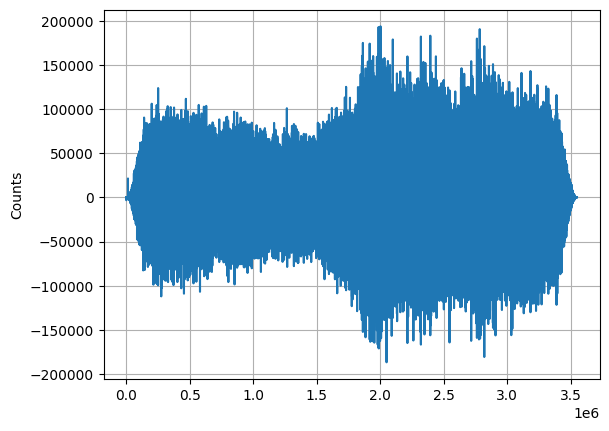

In [4]:
plt.plot(Z[0].data);plt.grid(True);plt.ylabel('Counts')

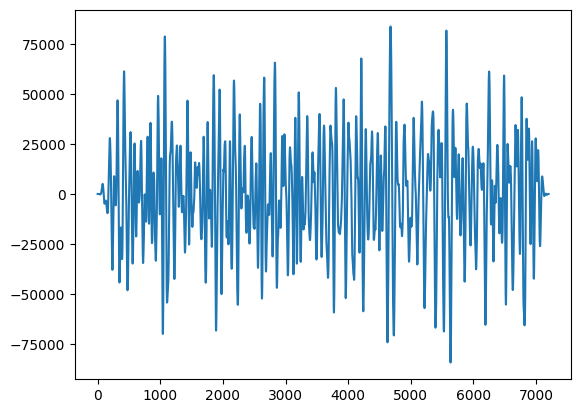

In [5]:
plt.plot(N[0].data)

**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

C:\Users\nmaik\AppData\Local\Temp\ipykernel_23284\3134257337.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\nmaik\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


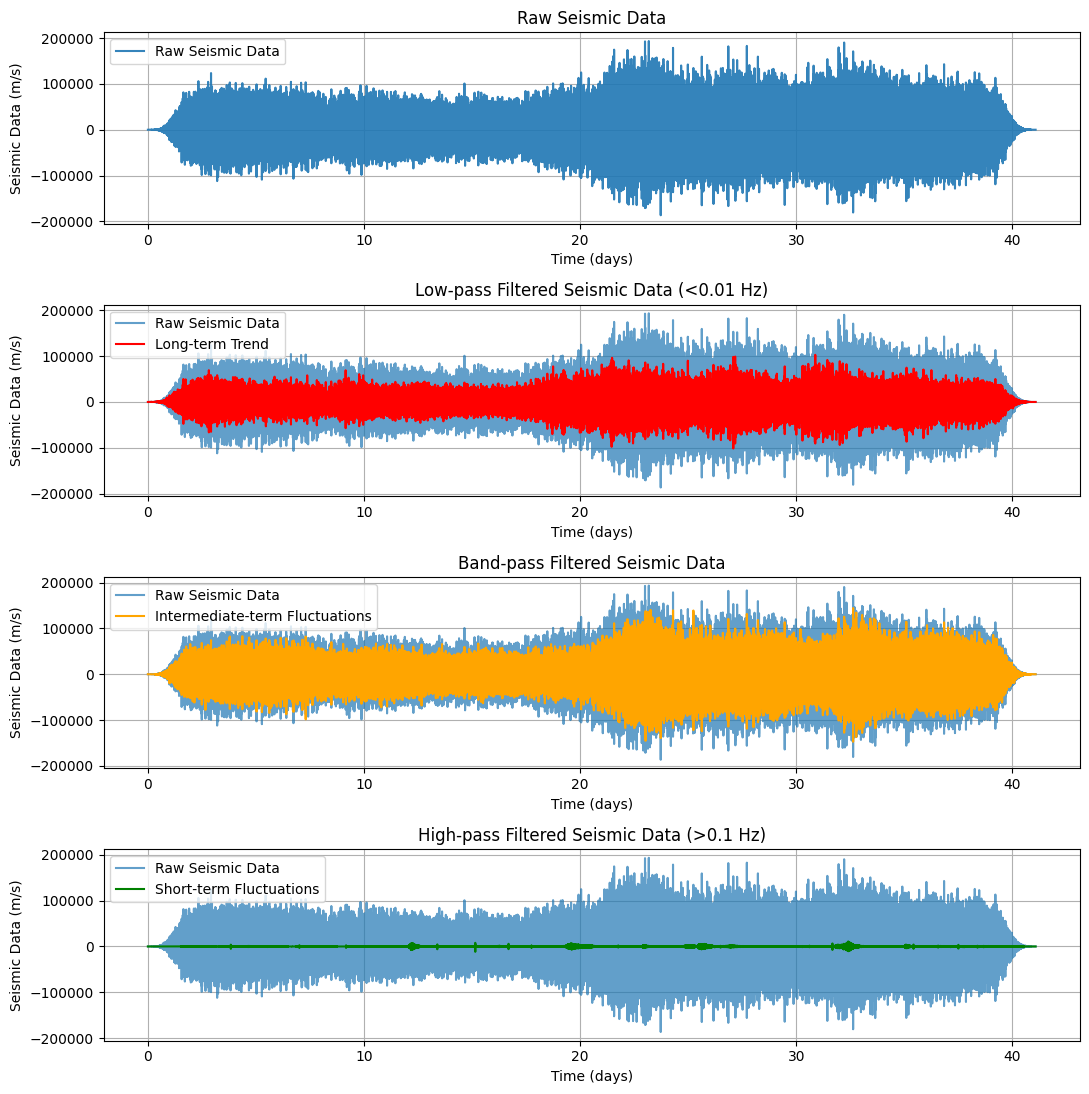

In [40]:
from scipy.signal import butter, filtfilt
import pandas as pd

# 0. Plot the raw data
# Plot the seismic data using Tstart and Tend to create a time axis in days

Ndays = (Z[0].stats.endtime-Z[0].stats.starttime)/86400. #s in 41 days
time_axis = np.linspace(0, Ndays, len(Z[0].data))

# 1. Apply low-pass filter to look at seismic frequencies below 0.01Hz, or 100 s period

# Define a Low-pass filter to isolate long-term trend
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
# Apply low-pass filter
cutoff = 1 / 100  # Cutoff frequency (0.01 Hz, or 100 s period)
fs = 1 / tr.stats.delta  # Sampling frequency (Hz)
b, a = butter_lowpass(cutoff, fs)
st_lowpass = filtfilt(b, a, Z[0].data)


# 2. Apply band-pass filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

# Define a Band-pass filter to isolate intermediate-term fluctuations
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a
# Apply band-pass filter
lowcut = 1 / 100  # Low cutoff frequency (0.01 Hz, or 100 s period)
highcut = 1 / 10  # High cutoff frequency (0.1 Hz, or 10 s period)
b, a = butter_bandpass(lowcut, highcut, fs) 
st_bandpass = filtfilt(b, a, Z[0].data)


# 3. Apply high-pass filter to look at seismic frequencies above 0.1Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz)

# Define a High-pass filter to isolate short-term fluctuations
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
# Apply high-pass filter
cutoff = 1 / 10  # Cutoff frequency (0.1 Hz, or 10 s period)
b, a = butter_highpass(cutoff, fs)
st_highpass = filtfilt(b, a, Z[0].data)


# make one plot with subplots for raw and filtered vs raw data
fig,ax=plt.subplots(4,1,figsize=(11,12))
# raw data
ax[0].plot(time_axis, Z[0].data, label='Raw Seismic Data', alpha=0.9)
ax[0].set_title('Raw Seismic Data')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Seismic Data (m/s)')
ax[0].legend()
ax[0].grid(True)
# low-pass filtered data
ax[1].plot(time_axis, Z[0].data, label='Raw Seismic Data', alpha=0.7)
ax[1].plot(time_axis, st_lowpass, label='Long-term Trend', color='red')
ax[1].set_title('Low-pass Filtered Seismic Data (<0.01 Hz)')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Seismic Data (m/s)')
ax[1].grid(True)
ax[1].legend()
# band-pass filtered data
ax[2].plot(time_axis, Z[0].data, label='Raw Seismic Data', alpha=0.7)
ax[2].plot(time_axis, st_bandpass, label='Intermediate-term Fluctuations', color='orange')
ax[2].set_title('Band-pass Filtered Seismic Data')
ax[2].set_xlabel('Time (days)')
ax[2].set_ylabel('Seismic Data (m/s)')
ax[2].grid(True)
ax[2].legend()
# high-pass filtered data
ax[3].plot(time_axis, Z[0].data, label='Raw Seismic Data', alpha=0.7)
ax[3].plot(time_axis, st_highpass, label='Short-term Fluctuations', color='green')
ax[3].set_title('High-pass Filtered Seismic Data (>0.1 Hz)')
ax[3].set_xlabel('Time (days)') 
ax[3].set_ylabel('Seismic Data (m/s)')
ax[3].grid(True)
ax[3].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# I like that these look like an aerial view of a beaver, lol

**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

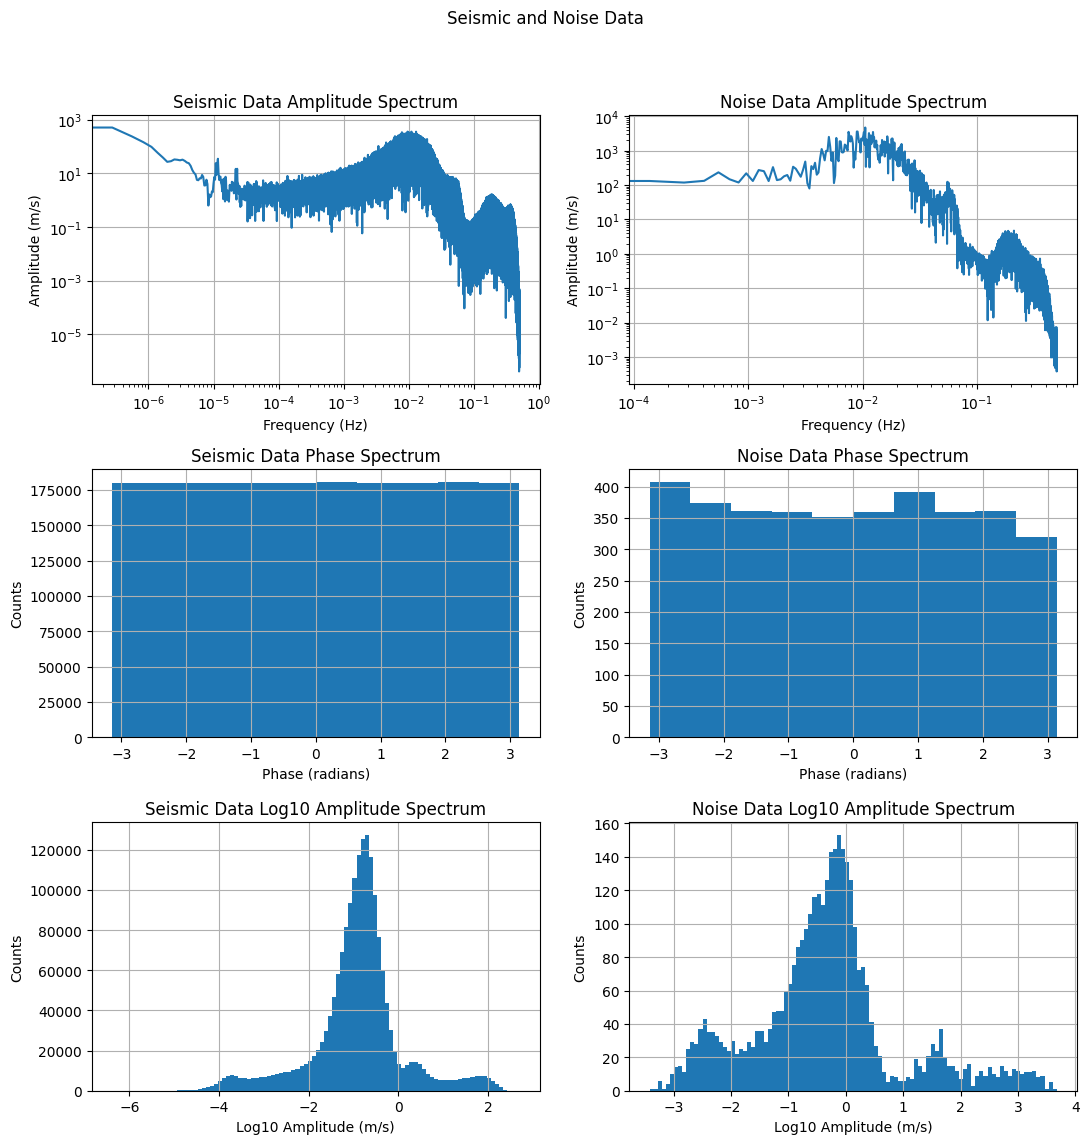

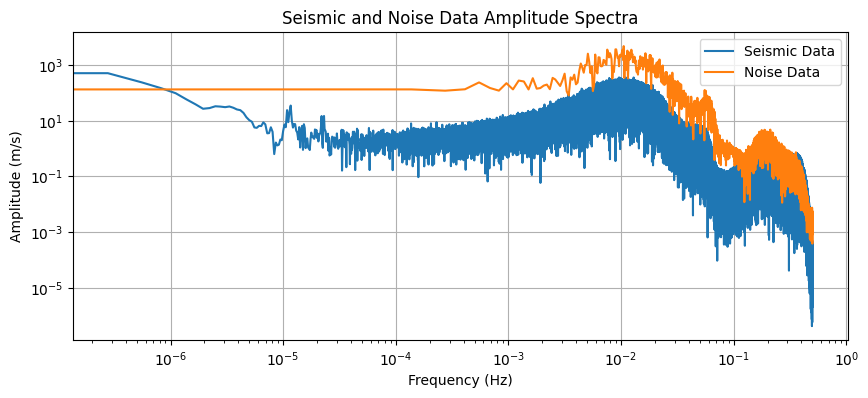

In [7]:
# compute the Fourier transform of the seismic time series
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len
npts = Z[0].stats.npts

## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
# create the frequency vector
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
# taper the data to enable periodicity
Z.taper(max_percentage=0.05)
# Fourier transform
Zhat = fft(Z[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)

# compute the Fourier transform of the noise time series
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len
npts1 = N[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft1 = next_fast_len(int(N[0].data.shape[0])) # this will be an even number
freqVec1 = fftfreq(Nfft1, d=N[0].stats.delta)[:Nfft1//2]
# taper the data to enable periodicity
N.taper(max_percentage=0.05)
# Fourier transform
Nhat = fft(N[0].data,n=Nfft1)#/np.sqrt(Z[0].stats.npts)


#Plot amplitude spectra, phase spectra, and histograms of log10 amplitude spectra for both seismic and noise data 
fig,ax=plt.subplots(3,2,figsize=(11,12))
plt.suptitle('Seismic and Noise Data')
# amplitude spectrum
ax[0,0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax[0,0].grid(True)
ax[0,0].set_xscale('log');ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('Frequency (Hz)');ax[0,0].set_ylabel('Amplitude (m/s)')
ax[0,0].set_title('Seismic Data Amplitude Spectrum')
ax[0,1].plot(freqVec1,np.abs(Nhat[:Nfft1//2])/Nfft1)
ax[0,1].grid(True)
ax[0,1].set_xscale('log');ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('Frequency (Hz)');ax[0,1].set_ylabel('Amplitude (m/s)')
ax[0,1].set_title('Noise Data Amplitude Spectrum')
# histogram of the phase spectrum
ax[1,0].hist(np.angle(Zhat[:Nfft//2]))
ax[1,0].grid(True)
ax[1,0].set_xlabel('Phase (radians)');ax[1,0].set_ylabel('Counts')
ax[1,0].set_title('Seismic Data Phase Spectrum')
ax[1,1].hist(np.angle(Nhat[:Nfft1//2]))
ax[1,1].grid(True)
ax[1,1].set_xlabel('Phase (radians)');ax[1,1].set_ylabel('Counts')
ax[1,1].set_title('Noise Data Phase Spectrum')
# histogram of the log10 of the amplitude spectrum
ax[2,0].hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100);ax[2,0].grid(True)
ax[2,0].set_xlabel('Log10 Amplitude (m/s)');ax[2,0].set_ylabel('Counts');
ax[2,0].set_title('Seismic Data Log10 Amplitude Spectrum')
ax[2,1].hist(np.log10(np.abs(Nhat[:Nfft1//2])/Nfft1),100);ax[2,1].grid(True)
ax[2,1].set_xlabel('Log10 Amplitude (m/s)');ax[2,1].set_ylabel('Counts');
ax[2,1].set_title('Noise Data Log10 Amplitude Spectrum')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# plot seismic and noise amplitudes on the same plot for comparison
plt.figure(figsize=(10,4))
plt.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft,label='Seismic Data')
plt.plot(freqVec1,np.abs(Nhat[:Nfft1//2])/Nfft1,label='Noise Data')
plt.xscale('log');plt.yscale('log');
plt.xlabel('Frequency (Hz)');plt.ylabel('Amplitude (m/s)');
plt.title('Seismic and Noise Data Amplitude Spectra');
plt.legend();plt.grid(True)
plt.show()


In [8]:
# Compute and print the skewness, kurtosis, mean, and standard deviation of the log10 of the amplitude spectra for both seismic and noise data
# print short float values
print(f"Skewness of ice vibrations {scipy.stats.skew(np.log10(np.abs(Zhat[:Nfft//2])))} and noise {scipy.stats.skew(np.log10(np.abs(Nhat[:Nfft1//2])))}")
#skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.

print(f"Kurtosis of ice vibrations {scipy.stats.kurtosis(np.log10(np.abs(Zhat[:Nfft//2])))} and noise {scipy.stats.kurtosis(np.log10(np.abs(Nhat[:Nfft1//2])))}")
# kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable.

print(f"Mean of ice vibrations {np.mean(np.log10(np.abs(Zhat[:Nfft//2])))} and noise {np.mean(np.log10(np.abs(Nhat[:Nfft1//2])))}")

print(f"standard deviation of ice vibrations {np.std(np.log10(np.abs(Zhat[:Nfft//2])))} and noise {np.std(np.log10(np.abs(Nhat[:Nfft1//2])))}")


Skewness of ice vibrations -0.22931859258191115 and noise 0.5172759157308696
Kurtosis of ice vibrations 2.1220708336802527 and noise 0.7693424470612173
Mean of ice vibrations 5.652413235979868 and noise 3.5187202292427884
standard deviation of ice vibrations 1.028557306583762 and noise 1.2850985786246116


Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?

The band-pass filtered data range (yellow) most closely resembles the raw data signal, and there appears to be a clear "peak" in both amplitude spectras centered at ~0.01 Hz (between 0.001-0.1).  Low frequency signals captured by the low-pass filter have low to modest amplitudes, and skew of data toward negative frequencies supports interpretations of long-term tectonic signals, rather than the target study's ice fracturing signal. High pass filtered data (green) is only a small portion of the overall signal, and alligns most heavily with the noise spectra. 

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

In [9]:
# Synthesize random noise with the same amplitude spectrum (>0.1 Hz) as the seismic data (with the same moment sensitivity to noise levels)
from numpy import random
from scipy.fftpack import ifft, ifftshift

#over the entire range of data
data = Z[0].data
noise = N[0].data
amp = np.abs(fft(N[0]))
phase = np.exp(1j * 2 * np.pi * random.rand(len(amp)))
synth_noise = np.real(ifft(amp * phase))

# generate pink noise (1/f)
def pink_noise(N):
    # Generate white noise
    white = np.random.normal(size=N)
    # FFT
    f = np.fft.rfft(white)
    # Create frequency array
    frequencies = np.fft.rfftfreq(N)
    # Avoid division by zero
    frequencies[0] = 1.0
    # Scale by 1/f
    f /= frequencies
    # Inverse FFT to get pink noise
    pink = np.fft.irfft(f, n=N)
    return pink
pink = pink_noise(len(data))



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


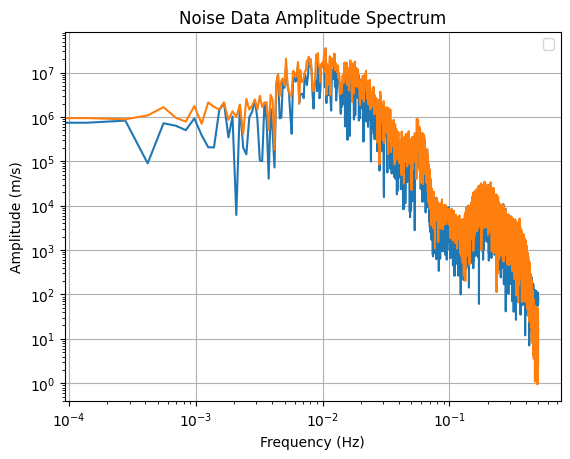

In [11]:
# Make noise based on the spectrum of the noise data
npts = N[0].stats.npts-1
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(N[0].data.shape[0]-1)) # this will be an even number
freqVec = fftfreq(Nfft, d=N[0].stats.delta)[:Nfft//2]
Nat = fft(synth_noise,n=Nfft)#/np.sqrt(Z[0].stats.npts)

# plot the noise amplitude spectrum
plt.plot(freqVec,np.abs(Nat[:Nfft//2]))
plt.xscale('log');plt.yscale('log');plt.grid()
# taper the data to enable periodicity
N.taper(max_percentage=0.05)
# Fourier transform
Nhat = fft(N[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)

# plot the noise amplitude spectrum
plt.plot(freqVec,np.abs(Nhat[:Nfft//2]))
plt.xscale('log');plt.yscale('log');plt.grid()
plt.xlabel('Frequency (Hz)');plt.ylabel('Amplitude (m/s)');
plt.title('Noise Data Amplitude Spectrum');
plt.legend();plt.grid(True)
plt.show()

**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

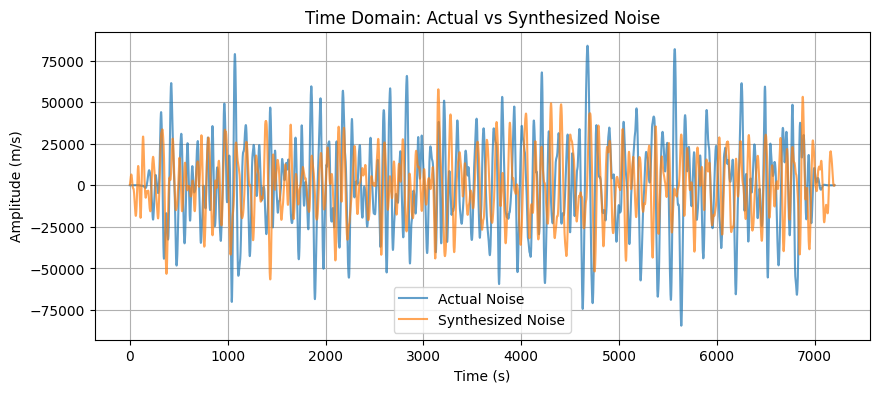

In [12]:
# plot the synthesized noise vs actual noise; repeat periodically over complete 41 days of seismic data
plt.figure(figsize=(10,4))
plt.plot(noise, label="Actual Noise", alpha=0.7)
plt.plot(synth_noise, label="Synthesized Noise", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (m/s)")
plt.legend()
plt.title("Time Domain: Actual vs Synthesized Noise")
plt.grid(True)
plt.show()



**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

37807.146489312254
16198.058685207732


C:\Users\nmaik\AppData\Local\Temp\ipykernel_23284\4181207740.py:28: RuntimeWarning: divide by zero encountered in log10
  ax[1].pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=0.5, shading='gouraud')


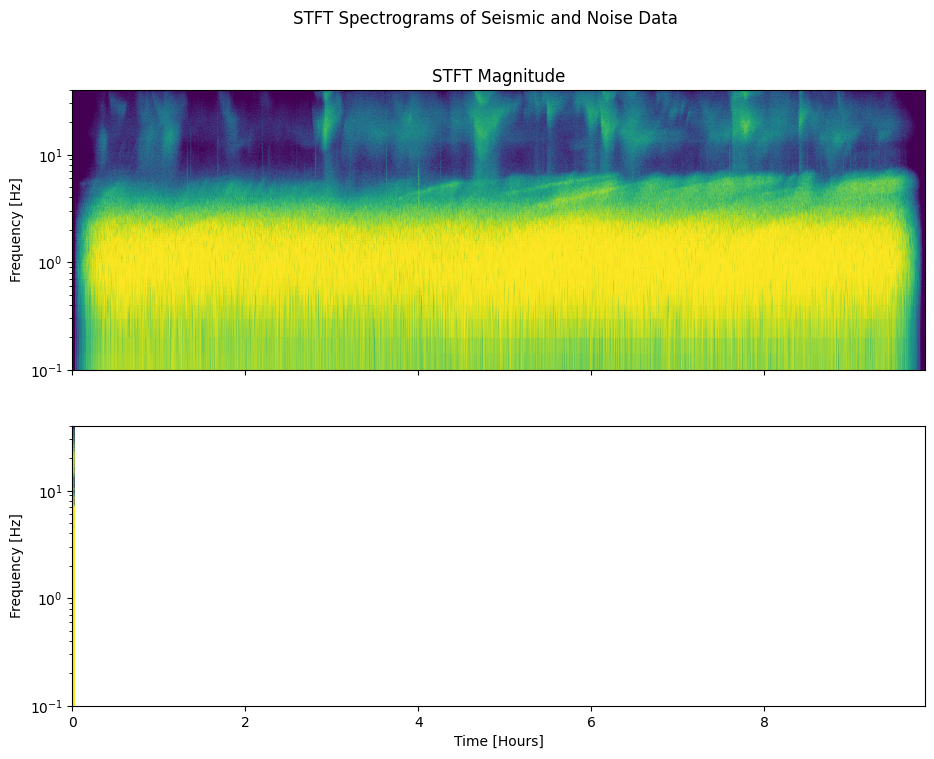

In [13]:
# Compute and plot the Short-Time Fourier Transform (STFT) spectrogram of the seismic data and the noise data
#import the STFT function
from scipy.signal import stft

# number of points in each segment
nperseg=1000
# treat data as a numpy array
z=np.asarray(Z[0].data)
# f is frequency, t is time, Zxx is the STFT of z
f, t, Zxx = stft(z, fs=100, nperseg=nperseg,noverlap=200)
# print the maximum value of the STFT
print(np.max(np.max(np.abs(Zxx))))

# plot the STFT spectrogram for the first period
fig,ax=plt.subplots(2,1,figsize=(11,8),sharex=True)
plt.suptitle('STFT Spectrograms of Seismic and Noise Data')
# plot the STFT spectrogram for the seismic data

ax[0].pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=3.5, shading='gouraud')
ax[0].set_title('STFT Magnitude')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_yscale('log');ax[0].set_ylim(0.1,40)

# plot the STFT spectrogram for the noise data (nhat)
n = np.asarray(N[0].data)
f, t, Zxx = stft(n, fs=100, nperseg=nperseg,noverlap=200)
print(np.max(np.max(np.abs(Zxx))))
ax[1].pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=0.5, shading='gouraud')
# ax[1].set_title('Noise Magnitude')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [Hours]');ax[1].set_yscale('log');ax[1].set_ylim(0.1,40)
plt.show()

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

Index(['Unnamed: 0', 'GPS_seconds', 'satellite_number',
       'variometric_derived_TEC', 'variometric_derived_TEC_filtered',
       'absolute_derived_TEC', 'absolute_derived_TEC_filtered',
       'latitude_piercing_point', 'longitude_piercing_point',
       'satellite_azimuth', 'satellite_elevation_angle',
       'distance_to_piercing_point', 'time'],
      dtype='object')


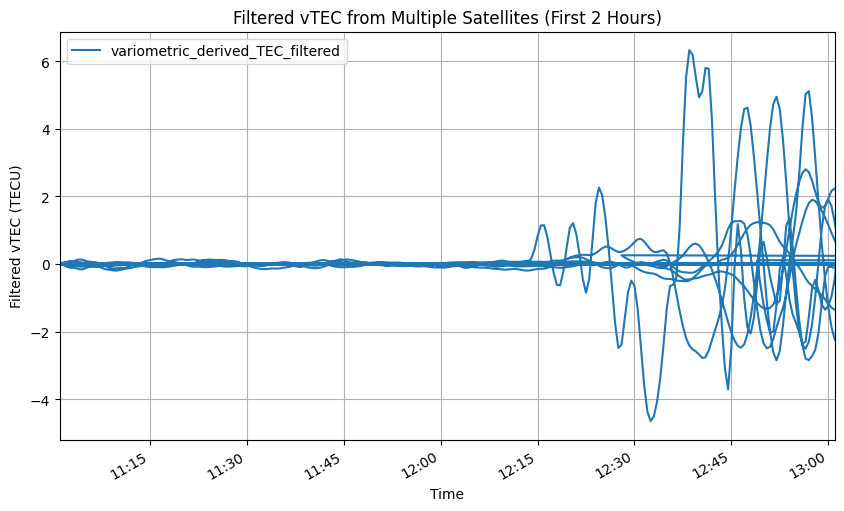

In [14]:
# answer below
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import os
# Make sure to adjust the path to where your CSV file is located
csv_path = "./TEC/ioncorr_samo_015_2022_tonga.csv"
# Check if the file exists
if not os.path.exists(csv_path):
    print(f"File not found: {csv_path}")
    print("Please check that the file exists at the specified path. If not, download or move it there.")
# If the file exists, proceed to read and plot the data
else:
    # Read the CSV file
    df = pd.read_csv(csv_path)
    #print the keys of the dataframe
    print(df.columns)
    # Convert the 'time' column to datetime format in seconds since epoch (1970-01-01)
    df['datetime'] = pd.to_datetime(df['time'], unit='s')
    # Plot the filtered vTEC for each satellite over time
    sat_cols = [col for col in df.columns if 'variometric_derived_TEC_filtered' in col]
    plt.figure(figsize=(10, 6))
    # Plot each satellite's filtered vTEC for the first 2 hours
    for col in sat_cols:
        plt.plot(df['datetime'], df[col], label=col)
    plt.xlim(df['datetime'].min(), df['datetime'].min() + pd.Timedelta(hours=2))
    plt.xlabel('Time')
    plt.ylabel('Filtered vTEC (TECU)')
    plt.title('Filtered vTEC from Multiple Satellites (First 2 Hours)')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()  # Rotate date labels automatically
    plt.show()

## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [15]:
# answer below
filename = "./TEC/ioncorr_samo_015_2022_tonga.csv"
station = filename.split("_")[1]
print("Station name:", station)

Station name: samo


## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

In [16]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(filename)
print("DataFrame columns:", df.columns)

# store satellite numbers in a list
satellite_numbers = []
print("Satellite Numbers:")



DataFrame columns: Index(['Unnamed: 0', 'GPS_seconds', 'satellite_number',
       'variometric_derived_TEC', 'variometric_derived_TEC_filtered',
       'absolute_derived_TEC', 'absolute_derived_TEC_filtered',
       'latitude_piercing_point', 'longitude_piercing_point',
       'satellite_azimuth', 'satellite_elevation_angle',
       'distance_to_piercing_point', 'time'],
      dtype='object')
Satellite Numbers:


Number of satellites: 1
Satellite columns: ['variometric_derived_TEC_filtered']


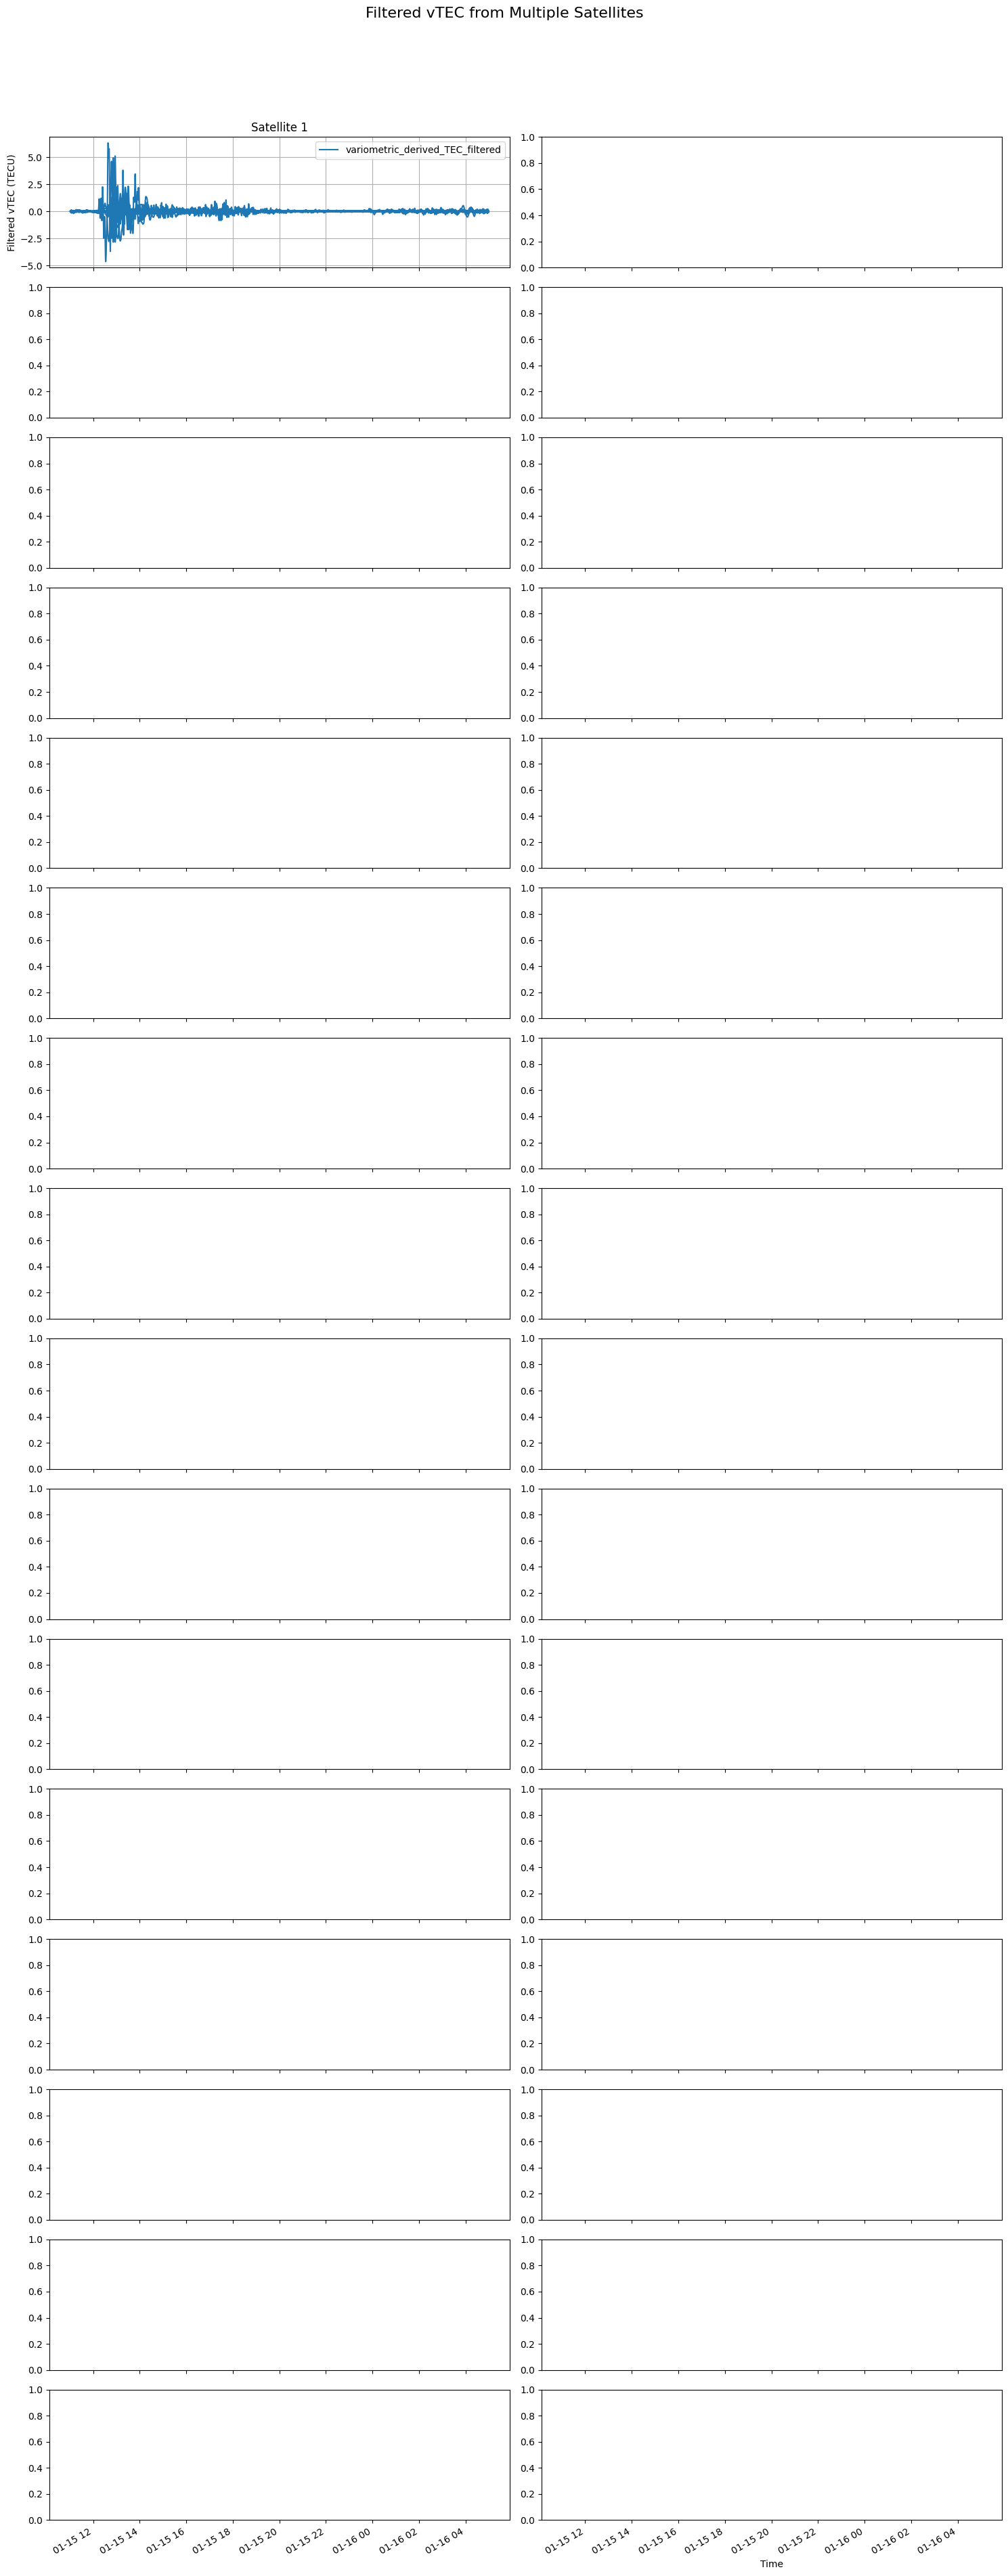

In [19]:
# index each satellite column
sat_cols = [col for col in df.columns if 'variometric_derived_TEC_filtered' in col]
print("Number of satellites:", len(sat_cols))
print("Satellite columns:", sat_cols)

#convert time from timestamp to numpy datetime64
df['datetime'] = pd.to_datetime(df['time'], unit='s').values.astype('datetime64[s]')
# set datetime as index
df.set_index('datetime', inplace=True)


#Use 16,2 subplots to plot all the satellite filtered vTEC data by seconds
fig, axes = plt.subplots(16, 2, figsize=(15, 40), sharex=True)
fig.suptitle('Filtered vTEC from Multiple Satellites', fontsize=16)
# flatten the axes array for easy indexing
axes = axes.flatten()
# plot each satellite's filtered vTEC data
for i, col in enumerate(sat_cols):
    axes[i].plot(df.index, df[col], label=col)
    axes[i].set_title(f'Satellite {i+1}')
    axes[i].set_ylabel('Filtered vTEC (TECU)')
    axes[i].legend()
    axes[i].grid(True)
# set x-axis label for the last subplot
axes[-1].set_xlabel('Time')
plt.gcf().autofmt_xdate()  # Rotate date labels automatically
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


You can now select one of the satellite observations that contain a full vTEC signal.

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. Select the time series of interest and plot the time series. What can you tell about the time-frequency characteristic of these disturbances?

In [20]:
# Select one satellite and plot its filtered vTEC time series
if 'df' not in globals() or 'sat_cols' not in globals():
    print("Data not loaded. Please ensure the CSV file exists and was loaded successfully.")
else:
    sat_col = sat_cols[0]
    tec = df[sat_col].values
    plt.plot(df['datetime'], tec)
    plt.xlabel("Time")
    plt.ylabel("Filtered vTEC (TECU)")
    plt.title("TEC for one satellite")
    plt.show()

KeyError: 'datetime'

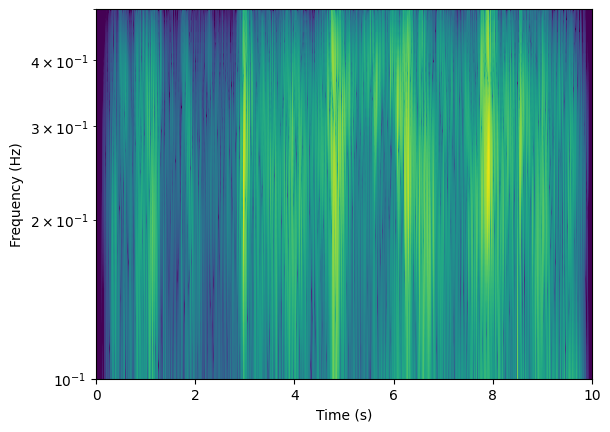

In [21]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Assuming Z and z are already defined
# Z: list of objects with .stats.delta attribute
# z: 1D array of the signal

# Define time vector and sampling frequency
Tstart = 0  # Define Tstart appropriately
Tend = 10  # Define Tend appropriately
t = np.arange(0, (Tend - Tstart) + Z[0].stats.delta, Z[0].stats.delta)  # time vector
fs = 1 / Z[0].stats.delta  # sampling frequency

# Number of scales to use
w = 6.0

# Relate scales with frequencies
freq = np.logspace(-1, np.log10(fs / 2), 100)
widths = w * fs / (2 * freq * np.pi)

# Compute the CWT
cwtm = signal.cwt(z, signal.morlet2, widths, w=w)
v1 = np.log10(np.abs(cwtm)).min()
v2 = np.log10(np.abs(cwtm)).max()
# Plot the CWT coefficients
plt.imshow(np.log10(np.abs(cwtm)), extent=[t.min(), t.max(), freq.min(), freq.max()], cmap='viridis', aspect='auto',
           vmin=v2-5, vmax=v2, origin='lower')
plt.yscale('log')
plt.ylim([freq.min(), freq.max()])

# Add x-axis label
plt.xlabel('Time (s)')

# Add y-axis label
plt.ylabel('Frequency (Hz)')

# Show the plot
plt.show()

Calculate the sampling frequency by taking the time difference between two samples.

In [22]:
import scipy.signal as signal


t = np.arange(0,(Tend-Tstart)+Z[0].stats.delta,Z[0].stats.delta) # time vector
fs=1/Z[0].stats.delta # sampling frequency

# number of scales to use
w = 6.

# relate scales with frequencies
freq = np.logspace(-1, np.log10(fs/2), 100)
widths = w*fs / (2*freq*np.pi)


cwtm = signal.cwt(z, signal.morlet2, widths, w=w)

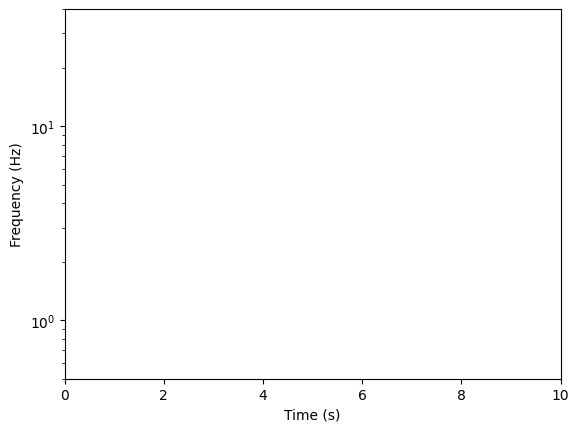

In [23]:
# cwtmatr = signal.cwt(z, signal.morlet, widths)
plt.imshow(np.log10(np.abs(cwtm)), extent=[t.min(),t.max(),freq.min(),freq.max()], cmap='viridis', aspect='auto',
           vmax=6, vmin=-0.5,origin='lower')
plt.yscale('log')
plt.ylim([0.5,40])


# Add x-axis label
plt.xlabel('Time (s)')  # Replace 'Time (s)' with the appropriate label for your data

# Add y-axis label
plt.ylabel('Frequency (Hz)')  # Replace 'Frequency (Hz)' with the appropriate label for your data


plt.show()

Perform the wavelet transform. You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

In [ ]:
import scipy.signal as signal
# use the number of scales
w = np.arange(1, 50)

# answer below
coef, freqs = signal.cwt(tec, signal.morlet2, w, w=6), w
plt.imshow(np.abs(coef), aspect='auto', extent=[0, len(tec)*dt/3600, w[-1], w[0]])
plt.xlabel("Time (hours)")
plt.ylabel("Scale")
plt.title("Wavelet Transform (Morlet)")
plt.colorbar(label="Amplitude")
plt.show()

NameError: name 'dt' is not defined

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

(answer below)

In [ ]:
# TO DO

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc``, ``NCM_SpatialGrid.nc``, and ``NCM_AuxData.nc``.

We first download the data from our Dropbox folder


In [25]:
import wget
# Download the geologic framework grids
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the auxiliary data
file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") #"./data/NCM_AuxData.nc"



In the following we will prepare our data. Read the DataSets using the python NetCDF4 library.

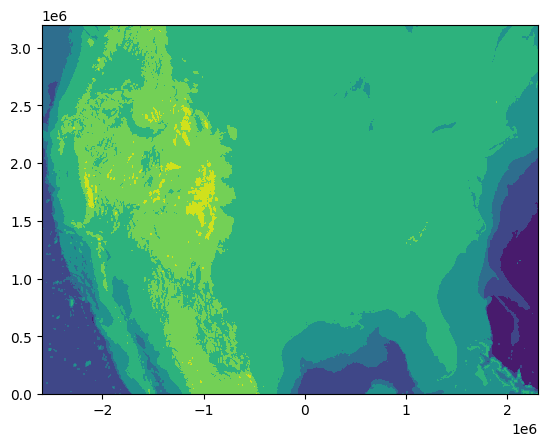

In [26]:
# Read the NetCDF files using netCDF4
#!pip install netCDF4
import netCDF4 as nc

ds1 = nc.Dataset(file1) # Geologic framework grids
ds2 = nc.Dataset(file2) # Coordinate grids
ds3 = nc.Dataset(file3) # Auxiliary data (WT, etc.)

# Extract geol. for plotting
WT = ds3.variables['Water Table Depth'][:]
elevation_surface = ds1.variables['Surface Elevation'][:]
elevation_bedrock = ds1.variables['Bedrock Elevation'][:]
elevation_Cz = ds1.variables['Bottom Cenozoic Elevation'][:]
elevation_Ph = ds1.variables['Bottom Phanerozoic Elevation'][:]
elevation_mid_crustal = ds1.variables['Mid Crustal Elevation'][:]
elevation_moho = ds1.variables['Moho Elevation'][:]
elevation_top_ocean_plate = ds1.variables['Top Ocean Plate Elevation'][:]

# create a grid of latitude and longitude
x = ds2['x'][0:4901, 0:3201]
y = ds2['y'][0:4901, 0:3201]
elevation = ds1['Surface Elevation'][0:4901, 0:3201]
plt.contourf(x, y, elevation)

# recreate the lat long vectors.
minlat,maxlat = min(ds2['Latitude vector'][:]),max(ds2['Latitude vector'][:])
minlon,maxlon = min(ds2['Longitude vector'][:]),max(ds2['Longitude vector'][:])
xlat = np.linspace(minlat,maxlat,3201)
xlon = np.linspace(minlon,maxlon,4901)




**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``, which are data sets from the NC files. Use the matplotlib function``contourf``, and the variables for lat long ``x`` and ``y`` . You can use the argument ``levels`` to the contourf funxtion to split the color map into discrete contour levels, and the transparency argument ``alpha`` to be less than 1.

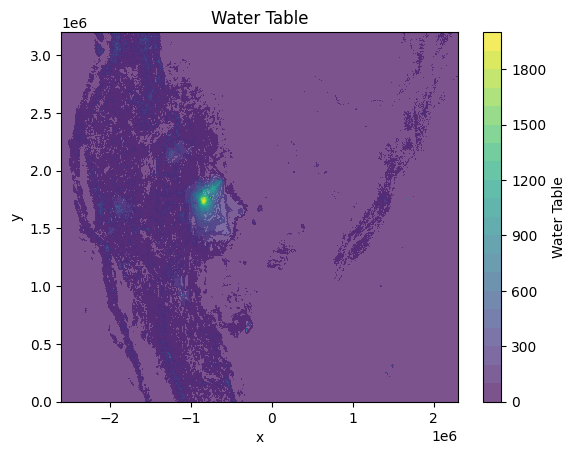

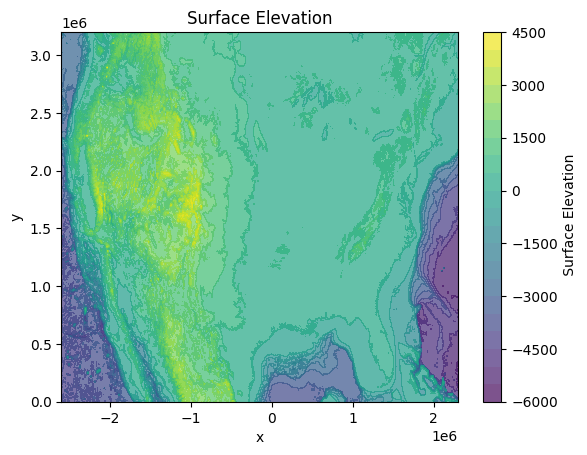

In [ ]:
# answer below
plt.figure()
plt.contourf(x, y, WT, levels=20, alpha=0.7)
plt.colorbar(label='Water Table')
plt.title('Water Table')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.contourf(x, y, elevation_surface, levels=20, alpha=0.5)
plt.colorbar(label=' Surface Elevation')
plt.title('Surface Elevation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**b. Perform and plot the 2D Fourier transforms (4 points)**


this is about the spatial sampling of the model  1.0777344413103096  km
this is about the spatial sampling of the model  1.5007397612756534  km


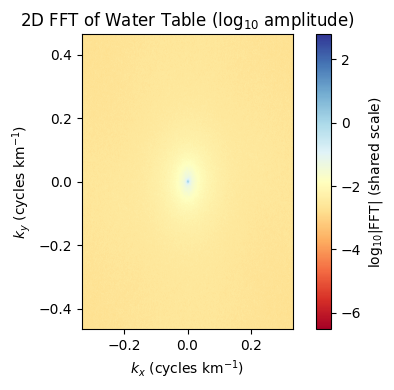

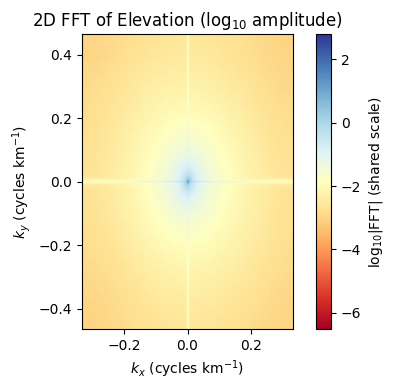

In [ ]:

# -------------------------------------------------------

# Convert degrees → km using ~111.25 km/deg (ok near mid-latitudes)

Rlat  = (xlat - xlat.min()) * 111.25        # km
dx    = Rlon[1] - Rlon[0]                   # km per pixel (x)
dRlat = Rlat[1]-Rlat[0]
print("this is about the spatial sampling of the model ",dRlat," km")

Rlon  = (xlon - xlon.min()) * 111.25        # km
dy    = Rlat[1] - Rlat[0]                   # km per pixel (y)
dRlon = Rlon[1]-Rlon[0]
print("this is about the spatial sampling of the model ",dRlon," km")


ny, nx = WT.shape                           # note (rows, cols) = (y, x)

# Spatial frequency vectors (cycles per km), centered with fftshift
kx = np.fft.fftfreq(nx, d=dx)               # length nx
ky = np.fft.fftfreq(ny, d=dy)               # length ny
kx = np.fft.fftshift(kx)
ky = np.fft.fftshift(ky)

klat = (fftfreq( 3201//2 , dRlat  )) 
klon = (fftfreq(4901//2,

#2D FFTs 
WT_fft   = np.fft.fftshift(np.fft.fft2(WT))
elev_fft = np.fft.fftshift(np.fft.fft2(elevation_surface))

# Log10 amplitude (normalized by number of points to compare fields)
eps = 1e-20
WT_log   = np.log10(np.abs(WT_fft)   / WT_fft.size + eps)
elev_log = np.log10(np.abs(elev_fft) / elev_fft.size + eps)

# Shared color scale
vmin = min(WT_log.min(), elev_log.min())
vmax = max(WT_log.max(), elev_log.max())

# Plot water table
plt.figure(figsize=(5,4))
plt.imshow(
    WT_log, origin="lower", cmap="RdYlBu", vmin=vmin, vmax=vmax,
    extent=[kx[0], kx[-1], ky[0], ky[-1]]
)
plt.title("2D FFT of Water Table (log$_{10}$ amplitude)")
plt.xlabel(r"$k_x$ (cycles km$^{-1}$)")
plt.ylabel(r"$k_y$ (cycles km$^{-1}$)")
plt.colorbar(label="log$_{10}$|FFT| (shared scale)")
#plt.axhline(0, color='k', lw=0.5, alpha=0.5)
#plt.axvline(0, color='k', lw=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

# Plot elevation
plt.figure(figsize=(5,4))
plt.imshow(
    elev_log, origin="lower", cmap="RdYlBu", vmin=vmin, vmax=vmax,
    extent=[kx[0], kx[-1], ky[0], ky[-1]]
)
plt.title("2D FFT of Elevation (log$_{10}$ amplitude)")
plt.xlabel(r"$k_x$ (cycles km$^{-1}$)")
plt.ylabel(r"$k_y$ (cycles km$^{-1}$)")
plt.colorbar(label="log$_{10}$|FFT| (shared scale)")
#plt.axhline(0, color='k', lw=0.5, alpha=0.5)
#plt.axvline(0, color='k', lw=0.5, alpha=0.5)
plt.tight_layout()
plt.show()




**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

In [ ]:
#TO DO

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

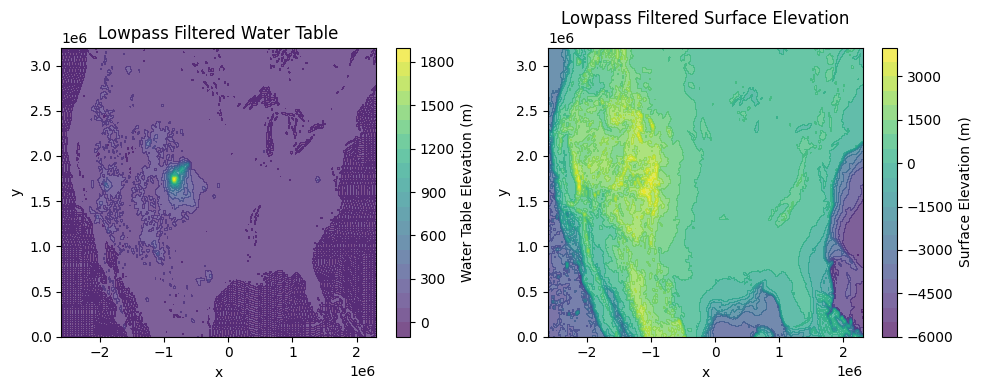

In [31]:
# solution
#from scipy.ndimage import gaussian_filter

#WT_lowpass = gaussian_filter(WT, sigma=5)
#plt.figure()
#plt.contourf(x, y, WT_lowpass, levels=20, alpha=0.7)
#plt.colorbar(label='Lowpass Water Table')
#plt.title('Lowpass Filtered Water Table')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()

# Apply low-pass filter to WT data
from scipy.signal import butter, filtfilt
import pandas as pd
# Define a Low-pass filter to isolate long-term trend
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
# Apply low-pass filter to WT data
cutoff = 1 / 50 # cutoff (0.025 cycles/km, or 40 km wavelength)
fs = 1 / dRlat  # Sampling frequency (Hz)
b, a = butter_lowpass(cutoff, fs)
WT_lowpass = filtfilt(b, a, WT, axis=0)
WT_lowpass = filtfilt(b, a, WT_lowpass, axis=1)
# Apply low-pass data to surface elevation data
elevation_lowpass = filtfilt(b, a, elevation_surface, axis=0)
elevation_lowpass = filtfilt(b, a, elevation_lowpass, axis=1)


# Plot the low-pass filtered WT and elevation data using plot.contourf
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(x, y, WT_lowpass, levels=20, alpha=0.7)
plt.colorbar(label='Water Table Elevation (m)')
plt.title('Lowpass Filtered Water Table')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.contourf(x, y, elevation_lowpass, levels=20, alpha=0.7)
plt.colorbar(label='Surface Elevation (m)')
plt.title('Lowpass Filtered Surface Elevation')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()



Now we will filter or compress by taking the largest Fourier coefficients of the image.

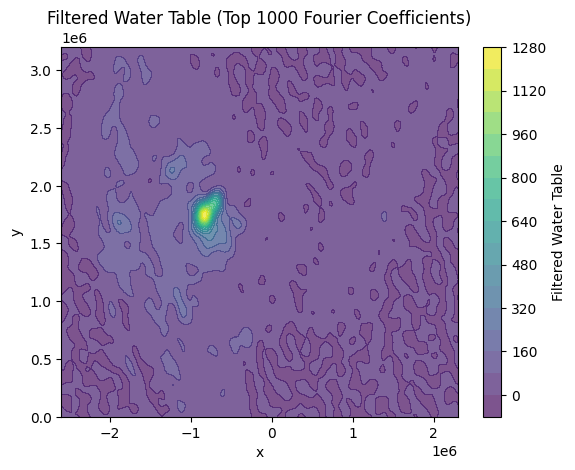

In [32]:
# Sort the Fourier coefficients
flat = np.abs(WT_fft).flatten()
idx = np.argsort(flat)[::-1]

# filter or compress by taking the largest Fourier coefficients
nkeep = 1000
mask = np.zeros(flat.shape, dtype=bool)
mask[idx[:nkeep]] = True
mask = mask.reshape(WT_fft.shape)
WT_filt = np.zeros(WT_fft.shape, dtype=complex)
WT_filt[mask] = WT_fft[mask]
# Inverse FFT to get the filtered WT data
WT_filt = np.fft.ifft2(np.fft.ifftshift(WT_filt)).real
# Plot the filtered WT data
plt.figure()
plt.contourf(x, y, WT_filt, levels=20, alpha=0.7)
plt.colorbar(label='Filtered Water Table')
plt.title('Filtered Water Table (Top 1000 Fourier Coefficients)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

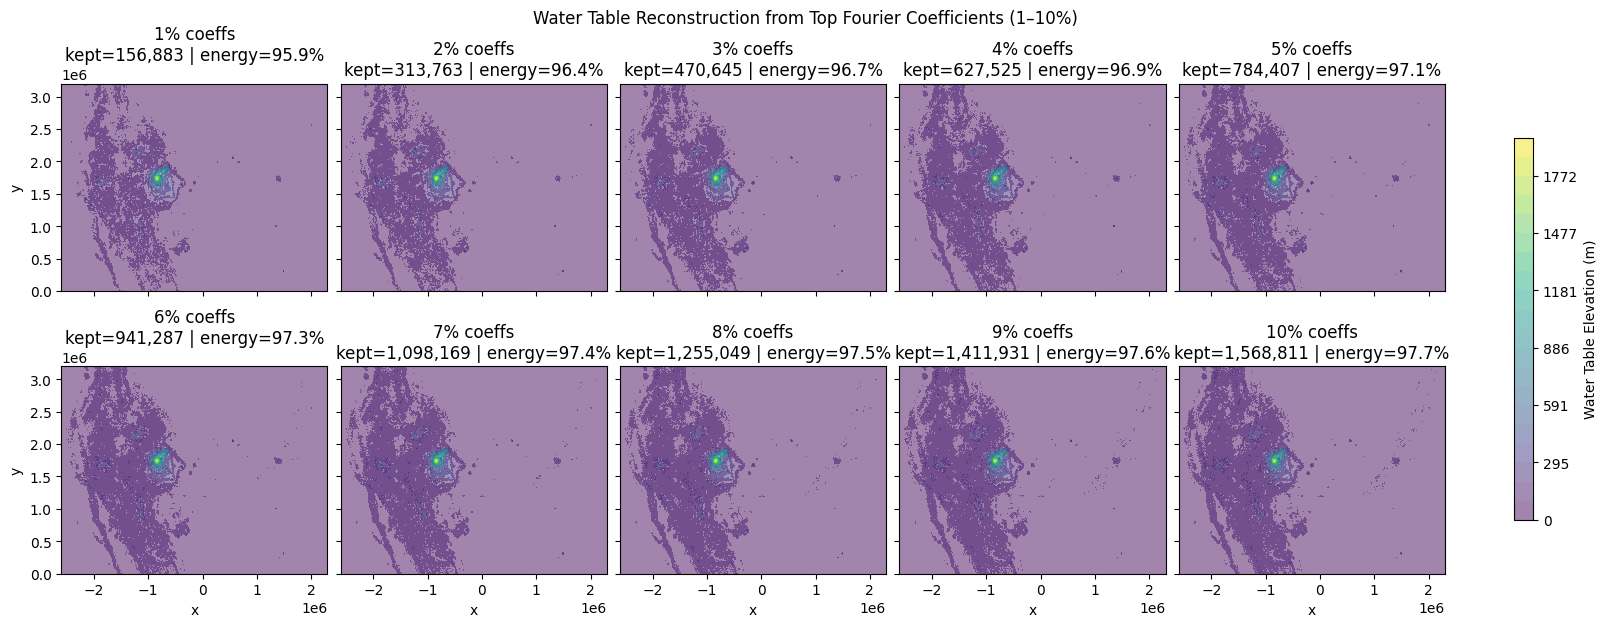

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def recon_topk_percent(field, keep_percent, enforce_symmetry=True, keep_dc=True):
    """
    field : 2D array (e.g., WT)
    keep_percent : percentage (0–100) of largest |F| coefficients to keep
    returns: recon (2D), n_kept (int), energy_fraction (0–1)
    """
    F      = np.fft.fft2(field)
    Fshift = np.fft.fftshift(F)

    # Sort by magnitude (descending)
    mags   = np.abs(Fshift).ravel()
    order  = np.argsort(mags)[::-1]

    K = max(1, int(np.ceil(keep_percent/100.0 * mags.size)))
    mask_flat = np.zeros_like(mags, dtype=bool)
    mask_flat[order[:K]] = True
    mask = mask_flat.reshape(Fshift.shape)

    # Enforce conjugate symmetry so IFFT is real
    if enforce_symmetry:
        mask = mask | np.flipud(np.fliplr(mask))

    # Always keep DC term
    if keep_dc:
        cy, cx = mask.shape[0]//2, mask.shape[1]//2
        mask[cy, cx] = True

    # Apply mask and invert
    Fk = np.where(mask, Fshift, 0)
    recon = np.fft.ifft2(np.fft.ifftshift(Fk)).real

    # Energy diagnostic (Parseval)
    energy_fraction = (np.abs(Fk)**2).sum() / (np.abs(Fshift)**2).sum()
    n_kept = int(mask.sum())
    return recon, n_kept, energy_fraction


# Reconstruct WT with 1% - 10% kept
percent_list = list(range(1, 11))  # 1..10%
vmin, vmax   = np.nanmin(WT), np.nanmax(WT)      # consistent levels
levels       = np.linspace(vmin, vmax, 21)

fig, axes = plt.subplots(2, 5, figsize=(16, 6), constrained_layout=True, sharex=True, sharey=True)
mappable = None

for i, p in enumerate(percent_list):
    WT_rec, n_kept, Efrac = recon_topk_percent(WT, p)

    ax = axes.flat[i]
    cs = ax.contourf(x, y, WT_rec, levels=levels, cmap='viridis', alpha = 0.5)
    ax.set_title(f"{p}% coeffs\nkept={n_kept:,} | energy={Efrac*100:.1f}%")
    if i % 5 == 0: ax.set_ylabel("y")
    if i >= 5:     ax.set_xlabel("x")
    mappable = cs

# single colorbar for all
cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.78)
cbar.set_label("Water Table Elevation (m)")
fig.suptitle("Water Table Reconstruction from Top Fourier Coefficients (1–10%)", y=1.02)
plt.show()


Now we will compare the original 2D data set with the Fourier compressed data


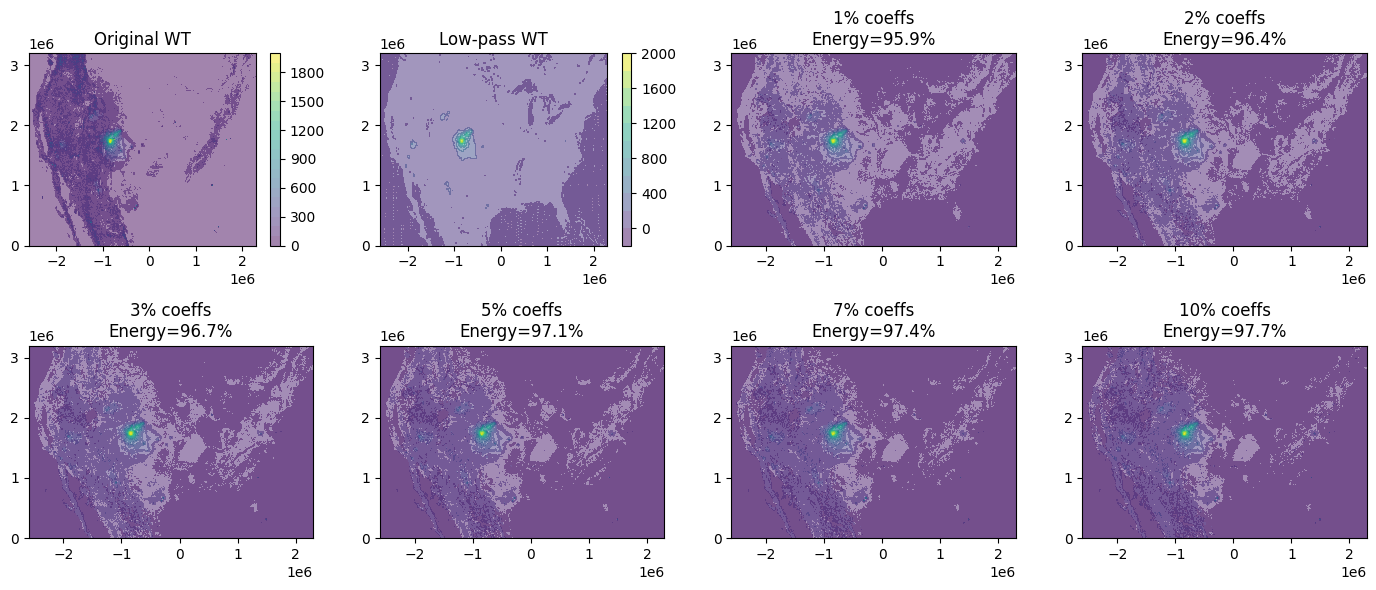

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# function to reconstruct field with a given % of Fourier coefficients
def reconstruct_percent(field, keep_percent):
    F = np.fft.fft2(field)
    Fshift = np.fft.fftshift(F)

    # flatten and sort coefficients by size
    flat = np.abs(Fshift).ravel()
    idx  = np.argsort(flat)[::-1]

    # build mask of top coefficients
    nkeep = int(keep_percent/100.0 * flat.size)
    mask = np.zeros_like(flat, dtype=bool)
    mask[idx[:nkeep]] = True
    mask = mask.reshape(Fshift.shape)

    # apply mask and invert
    Fnew = np.zeros_like(Fshift, dtype=complex)
    Fnew[mask] = Fshift[mask]
    rec = np.fft.ifft2(np.fft.ifftshift(Fnew)).real

    # energy fraction (how much of the “information” is kept)
    energy = np.sum(np.abs(Fnew)**2) / np.sum(np.abs(Fshift)**2)
    return rec, energy

# -------------------
# Plot results
# -------------------
fig, axes = plt.subplots(2, 4, figsize=(14,6))

# 1) Original
im0 = axes[0,0].contourf(x, y, WT, levels=20, cmap='viridis', alpha=0.5)
axes[0,0].set_title("Original WT")
fig.colorbar(im0, ax=axes[0,0])

# 2) Low-pass (your earlier filter)
im1 = axes[0,1].contourf(x, y, WT_lowpass, levels=10, cmap='viridis', alpha=0.5)
axes[0,1].set_title("Low-pass WT")
fig.colorbar(im1, ax=axes[0,1])

# 3) Reconstructions with 1–10% coefficients
percent_list = [1, 2, 3, 5, 7, 10]  # fewer plots to fit on page
for ax, p in zip(axes.flat[2:], percent_list):
    rec, Efrac = reconstruct_percent(WT, p)
    cs = ax.contourf(x, y, rec, levels=20, cmap='viridis', alpha=0.5)
    ax.set_title(f"{p}% coeffs\nEnergy={Efrac*100:.1f}%")

plt.tight_layout()
plt.show()
